In [1]:
import pandas as pd
df = pd.read_csv('bank-loan-dataset.csv', sep=";")

In [2]:
categorical_columns = ['job', 'marital', 'education', 'default', 'housing', 'loan',
    'contact', 'month', 'day_of_week', 'poutcome']

numerical_columns = ['age', 'duration', 'campaign', 'pdays', 'previous', 'emp.var.rate', 
    'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'nr.employed']

In [3]:
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, f1_score
from sklearn.model_selection import train_test_split

In [4]:
label_encoder = LabelEncoder()
df['labels'] = label_encoder.fit_transform(df['y'])

X = df.drop(columns=['y', 'labels'])
y = df['labels']

In [5]:
preprocessor = ColumnTransformer(
    transformers=[
        ('one_hot_encoder', OneHotEncoder(handle_unknown='ignore'), categorical_columns),
        ('standard_scaler', StandardScaler(), numerical_columns)
    ]
)

processed_X = preprocessor.fit_transform(X)

In [6]:
from imblearn.over_sampling import RandomOverSampler

ros = RandomOverSampler(random_state=42)
X_resampled, y_resampled = ros.fit_resample(processed_X, y)

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.3, random_state=42, shuffle=True)

In [9]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras import Sequential
from tensorflow.keras.metrics import AUC
from tqdm.keras import TqdmCallback

In [11]:
model = Sequential([
    Dense(128, activation='relu', input_shape=(processed_X.shape[1],)),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dropout(0.2),
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid')
])

model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy', AUC()] 
)

In [ ]:
history = model.fit(
    X_train, y_train,
    epochs=50,             # increase the epochs to train model very well
    verbose=0,              # disable default Keras logs
    callbacks=[TqdmCallback(verbose=1)]
)

In [14]:
loss, acc, auc = model.evaluate(X_test, y_test, verbose=1)

print(f"Loss : {loss:.2f}")
print(f"Accuracy Score (ACC): {acc:.2f}")
print(f"AUC Score: {auc:.2f}")

686/686 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9406 - auc_1: 0.9685 - loss: 0.1778
Loss : 0.18
Accuracy Score (ACC): 0.94
AUC Score: 0.97


In [15]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

predictions_prob = model.predict(X_test)
predictions = (predictions_prob > 0.5).astype(int)

print(f"Accuracy Score: {accuracy_score(y_test, predictions)}")
print(f"\nConfusion Matrix: \n{confusion_matrix(y_test, predictions)}")
print(f"\nClassification Report: \n{classification_report(y_test, predictions)}")

686/686 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
Accuracy Score: 0.9403985589858178

Confusion Matrix: 
[[ 9775  1230]
 [   77 10847]]

Classification Report: 
              precision    recall  f1-score   support

           0       0.99      0.89      0.94     11005
           1       0.90      0.99      0.94     10924

    accuracy                           0.94     21929
   macro avg       0.95      0.94      0.94     21929
weighted avg       0.95      0.94      0.94     21929



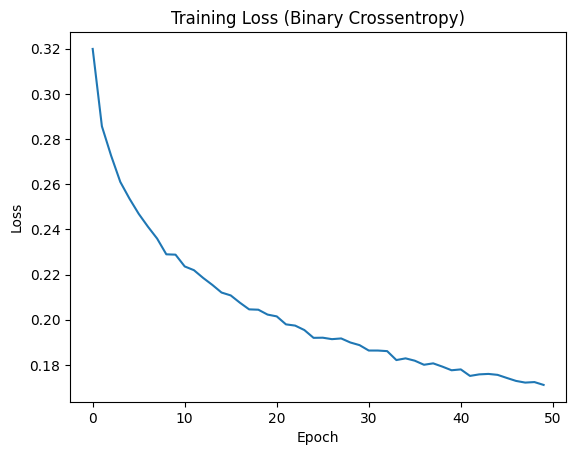

In [16]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'])
plt.title("Training Loss (Binary Crossentropy)")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()